**Only models**

# Problem description

https://dengueforecasting.noaa.gov/docs/Metadata.pdf

https://www.ncei.noaa.gov/products/climate-data-records

https://www.ncei.noaa.gov/products/climate-data-records/normalized-difference-vegetation-index

## Setup

Mixed libraries

In [137]:
#from google.colab import drive
import os
from copy import deepcopy
from pprint import pprint
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib.patches import Circle, ConnectionPatch

from joblib import dump, load

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf#, plot_pair

Sklearn library

In [138]:
#Utilities
from sklearn.metrics import SCORERS
from sklearn.base import clone
# Model
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, GradientBoostingRegressor, AdaBoostRegressor, VotingRegressor, StackingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import Lasso, Ridge, LassoCV, SGDRegressor, RidgeCV, ElasticNet, LinearRegression#, TweedieRegressor
from sklearn.svm import SVR
# Model selection 
from sklearn.model_selection import train_test_split, GridSearchCV
# Metrics
from sklearn.metrics import mean_squared_error, median_absolute_error, mean_absolute_error
# Preprocessing
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler, RobustScaler
# Feature selection
from sklearn.feature_selection import SelectFromModel, SelectKBest

Keras and Tensorflow

In [ ]:
from keras import layers, metrics, losses, Sequential, optimizers, callbacks, preprocessing, activations
import tensorflow as tf

In [139]:
def null_summary(df, rows=None):
    if rows == None:
        rows = df.shape[0]
    result = pd.concat((df.isnull().sum().rename("Number null"),
                        (100 * df.isnull().sum() / rows).rename("Perc null")),
                       axis=1)
    return result

def impute_nulls(df, columns=None, method="mean"):
    if isinstance(columns, type(None)):
        columns = df.columns
    if method == "mean":
        imputation_values = df[columns].mean().to_dict()
    elif method == "median":
        imputation_values = df[columns].median().to_dict()
    temp = df.copy()
    temp.loc[:, columns] = temp[columns].fillna(imputation_values).copy() # .isnull().sum()
    return temp
    
def extended_describe(dataframe, include="float"):
    # coefficient of variation
    rows = dataframe.shape[0]
    simple_stats = dataframe.describe(include=include).drop(["count"]).T
    simple_stats["90%"] = dataframe.quantile(0.90)
    simple_stats["cv"] = simple_stats["std"].div(simple_stats["mean"])
    # unbiased estimator coefficient of variation
    simple_stats["unbiased_cv"] = (1 + (1 / (4 * rows))) * simple_stats["std"]
    # quartile coefficient of dispersion
    simple_stats["qcd"] = (simple_stats["75%"] - simple_stats["25%"]) / \
        (simple_stats["75%"] + simple_stats["25%"])
    # MAD (deprecated)
    #simple_stats["MAD"] = dataframe.mad()
    # IQR
    simple_stats["IQR"] = simple_stats["75%"] - simple_stats["25%"]

    return simple_stats.T

def extended_describe_serie(serie, include="float"):
    # coefficient of variation
    rows = serie.shape[0]
    simple_stats = serie.describe(include=include).drop(["count"]).T
    simple_stats["90%"] = serie.quantile(0.90)
    simple_stats["cv"] = simple_stats["std"] / simple_stats["mean"]
    # unbiased estimator coefficient of variation
    simple_stats["unbiased_cv"] = (1 + (1 / (4 * rows))) * simple_stats["std"]
    # quartile coefficient of dispersion
    simple_stats["qcd"] = (simple_stats["75%"] - simple_stats["25%"]) / \
        (simple_stats["75%"] + simple_stats["25%"])
    # MAD (deprecated)
    #simple_stats["MAD"] = serie.mad()
    # IQR
    simple_stats["IQR"] = simple_stats["75%"] - simple_stats["25%"]

    return simple_stats.T

def multi_boxplot_hist(df, bins=None, axes_fc="lightgray", fig_fc="gray", figsize=(14, 24)):
    temp = df.select_dtypes(float)
    number_rows, number_columns = temp.shape
    fig, axes = plt.subplots(number_columns - 1, 2, figsize=(10, 24))

    fig.set_facecolor(fig_fc)
    if bins == None:
      bins = int(np.sqrt(number_rows))
    
    for column, ax in zip(temp.columns, axes):
      sns.boxplot(data=temp, x=column, ax=ax[0], orient="h")
      ax[0].set_facecolor(axes_fc)
      sns.histplot(data=temp, x=column, ax=ax[1], bins=bins)
      ax[1].set_facecolor(axes_fc)
      #sns.violinplot(data=temp, y=column, inner="points", ax=ax[2], alpha=0.6) # , palette="light:g"
    plt.tight_layout()

def multi_plot_numerical(df, which_plot="boxplot", IQR_prop=2.0, bins=None, stat="probability", axes_fc="lightgray", fig_fc="gray"):
    temp = df.select_dtypes(float)
    number_rows, number_columns = temp.shape
    fig, axes = plt.subplots(number_columns - 1, 1, figsize=(16, 24))
    fig.set_facecolor(fig_fc)

    if which_plot == "hist":
        if bins == None:
            bins = int(np.sqrt(number_rows))

    for column, ax in zip(temp.columns, axes):
      if which_plot == "hist":
          sns.histplot(data=temp, x=column, ax=ax, bins=bins, stat=stat)
          ax.set_facecolor(axes_fc)
      else:
          sns.boxplot(data=temp, x=column, 
                      ax=ax, 
                      orient="h", 
                      whis=IQR_prop, 
                      showmeans=True,
                      meanprops={"marker":"o",
                       "markerfacecolor":"white", 
                       "markeredgecolor":"black",
                      "markersize":"10"}
                      )
          sns.stripplot(data=temp, x=column, ax=ax, orient="h", color="red", 
                        alpha=0.2,
                        size=1
                        )
          ax.set_facecolor(axes_fc)
    plt.tight_layout()
    
def detect_outliers_IQR_serie(serie, IQR_prop=1.5):
    # test function: pass a serie
    stats = extended_describe_serie(serie)
    Q1, Q3, IQR = stats.loc[["25%", "75%", "IQR"]]
    # returns data points which are NOT between the range
    return ~serie.between(Q1 - IQR_prop * IQR, Q3 + IQR_prop * IQR)

def detect_outliers_IQR_df(df, IQR_prop=1.5):
    # test function: pass a dataframe
    stats = extended_describe(df)
    temp = df.copy()
    for col in temp.columns:
        Q1, Q3, IQR = stats.loc[["25%", "75%", "IQR"], col]
        # returns data points which are NOT between the range
        temp[col] = ~temp[col].between(Q1 - IQR_prop * IQR, Q3 + IQR_prop * IQR)
    return temp.astype(int)

def correct_outliers_to_IQR(df, IQR_prop=1.5, full_bounded=False, low_bounded=False, up_bounded=False, custom_bounds=(0.0, 100.0)):
    temp = df.copy()
    stats = extended_describe(temp)
    lower_bound, upper_bound = custom_bounds
    print('column | bot_value | top_value | IQR | Q3')

    for col in temp.columns:
      Q1, Q3, IQR = stats.loc[["25%", "75%", "IQR"], col]
      top_val = Q3 + IQR_prop * IQR
      bot_val = Q1 - IQR_prop * IQR
      if full_bounded:
        top_val = np.array([top_val])
        bot_val = np.array([bot_val])

        top_val = np.clip(top_val, lower_bound, upper_bound)[0]
        bot_val = np.clip(bot_val, lower_bound, upper_bound)[0]
      elif low_bounded:
        bot_val = lower_bound if bot_val < lower_bound else bot_val
      elif up_bounded:
        top_val =  upper_bound if top_val > upper_bound else top_val
      print(col, bot_val, top_val, IQR, Q3)
      
      # Correct lower outliers
      temp.loc[:, col] = temp[col].where(temp[col] >= bot_val, bot_val)
      # Correct upper outliers
      temp.loc[:, col] = temp[col].where(temp[col] <= top_val, top_val)
    return temp

In [140]:
def plot_pair(df, pairs, main_col, figsize=(12, 12), cols=4):
  number_columns = len(pairs)
  extra_rows = (cols - number_columns % cols)
  fig, axes = plt.subplots((number_columns + extra_rows) // cols, cols, figsize=figsize)
  
  for ax, sec_column in zip(axes.ravel(), pairs[main_col]):
    ax.scatter(df[sec_column], df[main_col])
    ax.set_xlabel(sec_column)
    ax.set_ylabel(main_col)
  plt.tight_layout()

In [141]:
def read_data(name_data="dengue_features_train.csv", name_target="dengue_labels_train.csv", on_train=True):
  data = training_features = pd.read_csv(name_data, index_col='week_start_date')

  training_labels = pd.read_csv(name_target)

  if on_train:
    data = data.reset_index().merge(training_labels, how='inner', on=['city', 'year', 'weekofyear']).set_index('week_start_date')
    data.total_cases = data.total_cases.astype(float)

  city_to_integer = {'sj': 0, 'iq':1}

  data.city = data.city.replace(city_to_integer).astype(int)

  data.index = pd.to_datetime(data.index, yearfirst=True, format='%Y-%m-%d', infer_datetime_format=True)

  return data

def mag_homogenized(df):
  KELVIN_TO_CELSIUS = 273.15
  RANDOM_STATE = 117  
  temp = df.copy()

  temp.loc[:, 'reanalysis_max_air_temp_c'] = \
    temp.loc[:, 'reanalysis_max_air_temp_k'] - KELVIN_TO_CELSIUS

  temp.loc[:, 'reanalysis_min_air_temp_c'] = \
    temp.loc[:, 'reanalysis_min_air_temp_k'] - KELVIN_TO_CELSIUS
  
  temp.loc[:, 'reanalysis_avg_temp_c'] = \
    temp.loc[:, 'reanalysis_avg_temp_k'] - KELVIN_TO_CELSIUS

  temp.loc[:, 'reanalysis_dew_point_temp_c'] = \
    temp.loc[:, 'reanalysis_dew_point_temp_k'] - KELVIN_TO_CELSIUS
  
  temp.loc[:, 'reanalysis_air_temp_c'] = \
    temp.loc[:, 'reanalysis_air_temp_k'] - KELVIN_TO_CELSIUS

  to_drop = ['reanalysis_max_air_temp_k', 'reanalysis_min_air_temp_k', 'reanalysis_avg_temp_k',
             'reanalysis_dew_point_temp_k', 'reanalysis_air_temp_k', 'reanalysis_sat_precip_amt_mm'
             ]
  temp.rename(columns={'reanalysis_tdtr_k': 'reanalysis_tdtr_c'}, inplace=True)
  temp.drop(to_drop, axis=1, inplace=True)

  return temp

def outlier_correction(df, IQR_prop=3.0, on_full_unbounded=False, lower_bounded_cols=None, bounded_cols=None, non_treated=None):
  temp = df.copy()
  lower_bounded_cols = ['precipitation_amt_mm', 
                        'reanalysis_precip_amt_kg_per_m2',
                        #'reanalysis_sat_precip_amt_mm',
                        'reanalysis_specific_humidity_g_per_kg',
                        'reanalysis_tdtr_c',
                        'station_diur_temp_rng_c',
                        'station_precip_mm'
                        ]

  bounded_cols = ['reanalysis_relative_humidity_percent']

  non_treated = ['total_cases']

  all_columns = temp.select_dtypes(float).columns
  
  unbounded_cols = [c for c in all_columns if c not in (lower_bounded_cols + bounded_cols + non_treated)]

  print(len(lower_bounded_cols), len(bounded_cols), len(non_treated), len(unbounded_cols), len(all_columns))
  print(unbounded_cols)
  # Unbounded features
  temp.loc[:, unbounded_cols] = correct_outliers_to_IQR(temp[unbounded_cols], IQR_prop=IQR_prop)

  if on_full_unbounded:
    return temp
  
  # lower-bound features
  temp.loc[:, lower_bounded_cols] = correct_outliers_to_IQR(temp[lower_bounded_cols], IQR_prop=IQR_prop, low_bounded=True)

  # bounded features (percentage)
  temp.loc[:, bounded_cols] = correct_outliers_to_IQR(temp[bounded_cols], IQR_prop=IQR_prop, full_bounded=True, custom_bounds=(0.0, 100.0))

  # custom bounded features (input bounds)
  #temp.loc[:, custom_bounded_cols] = correct_outliers_to_IQR(temp[bounded_cols], IQR_prop=IQR_prop, full_bounded=True, custom_bounds=())

  return temp

def null_correction(df, strategy='KNN'):
  temp = df.copy()
  
  if strategy == 'KNN':
    from sklearn.impute import KNNImputer
    knn_imputer = KNNImputer()
    temp.loc[:, temp.select_dtypes(float).columns] = knn_imputer.fit_transform(temp.select_dtypes(float))
  elif strategy == 'iter':
    from sklearn.impute import IterativeImputer
    iter_imputer = IterativeImputer()
    temp.loc[:, temp.select_dtypes(float).columns] = iter_imputer.fit_transform(temp.select_dtypes(float))
  elif strategy in ['mean', 'median']:
    from sklearn.impute import SimpleImputer
    simple_imputer = SimpleImputer(strategy=strategy)
    temp.loc[:, temp.select_dtypes(float).columns] = simple_imputer.fit_transform(temp.select_dtypes(float))
  return temp

def drop_features_from_reanalysis(df):
  reanalysis_to_drop = ['reanalysis_max_air_temp_c',
                        'reanalysis_min_air_temp_c',
                        'reanalysis_avg_temp_c',
                        'reanalysis_air_temp_c',
                        'reanalysis_tdtr_c',
                        #'reanalysis_sat_precip_amt_mm',
                        ]
  temp = df.copy()
  temp.drop(reanalysis_to_drop, axis=1, inplace=True)
  return temp

def weekofyear_to_season(df, on_dummies=True):
  temp = df.index.to_series().copy()
  seasonInt_to_season = {1: "winter", 2: "spring", 3: "summer", 4: "fall"}
  if on_dummies:
    dummy_cols = pd.get_dummies((temp.dt.month % 12 // 3 + 1).replace(seasonInt_to_season), prefix='is', drop_first=True)
    return pd.concat((df, dummy_cols), axis=1)
  else:
    return (temp.dt.month % 12 // 3 + 1).replace(seasonInt_to_season).rename('season')

def weekofyear_to_month(df, on_dummies=True):
  temp = df.index.to_series().copy()
  monthInt_to_month = {1: "January", 2: "February", 3: "March", 4: "April", 
                       5: "May", 6: "June", 7: "July", 8: "August", 
                       9: "September", 10: "October", 11: "November", 12: "December"}
  if on_dummies:
    dummy_cols = pd.get_dummies((temp.dt.month).replace(monthInt_to_month), prefix='is', drop_first=True)
    return pd.concat((df, dummy_cols), axis=1)
  else:
    return (temp.dt.month).replace(monthInt_to_month).rename('month')

def weekofmonth_to_dummies(df):
  intweek_to_strweek = {0: "firstweek", 
                         1: "secondweek", 
                         2: "thirdweek", 
                         3: "fourthweek"
                         }
  weekofmonth = pd.Series((df.weekofyear - 1) % 4 ).replace(intweek_to_strweek)
  dummy_cols = pd.get_dummies(weekofmonth, 
                              prefix='is', 
                              drop_first=True)
  return pd.concat((df, dummy_cols), axis=1)

def add_features_functions(df, reject_target='total_cases'):
  temp = df.drop(reject_target, axis='columns', errors='ignore').copy()

  df_to_sqrt = temp.select_dtypes(float).iloc[:, 4:].applymap(lambda x: np.sqrt(1 + x)).copy()
  df_to_sqrt.columns = [col + '_sqrt' for col in df_to_sqrt.columns]

  #df_to_square = temp.select_dtypes(float).applymap(np.square).copy()
  #df_to_square.columns = [col + '_square' for col in df_to_square.columns]

  return pd.concat((df.copy(), df_to_sqrt), axis=1)

def add_features_ndvi(df):
  temp = df.copy()

  ndvi_cols = ['ndvi_ne', 'ndvi_nw', 'ndvi_se', 'ndvi_sw']
  ndvi_data = temp.loc[:, ndvi_cols]

  for n, col1 in enumerate(ndvi_cols):
    for col2 in ndvi_cols[n + 1:]:
        temp[col1 + col2[4:]] = (ndvi_data.loc[:, col1] - ndvi_data.loc[:, col2])
        print(col1 + col2[4:])
  return temp

def shift_1_week(df, shift_direc=-1):
  temp = df.copy()
  
  shifted_target = temp.loc[:, ['city', 'total_cases']].groupby('city').shift(shift_direc)
  # forward fill na values in target
  temp.loc[:, 'total_cases'] = shifted_target.fillna(method='ffill')

  return temp

def detect_uncorrelated(df, corr_limit=0.3, strategy='limit', threshold_lim=3):
  temp = df.copy()
  total_cols = temp.columns
  corr_mat = df.select_dtypes(float).corr().abs()
  float_cols = corr_mat.columns
  
  col_to_correlated_cols = {}
  cols_with_correlations = []

  for n, col1 in enumerate(float_cols):
    col_to_correlated_cols[col1] = []
    for col2 in float_cols[n + 1:]:
      if corr_mat.loc[col1, col2] >= corr_limit:
        col_to_correlated_cols[col1].append(col2)

    if strategy == 'limit':
      if len(col_to_correlated_cols[col1]) >= threshold_lim:
        cols_with_correlations.append(col1)

  # columns enough correlations, columns with few correlations
  #return cols_with_correlations, [c for c in total_cols if c not in cols_with_correlations]
  return temp.loc[:, [c for c in total_cols if c not in cols_with_correlations]]

def extract_transform(name_data="dengue_features_train.csv", name_target="dengue_labels_train.csv", remove_corelated=False):
  data = read_data(name_data="dengue_features_train.csv", name_target="dengue_labels_train.csv", on_train=True)

  data = mag_homogenized(data)

  data = outlier_correction(data, IQR_prop=3.0)

  data = null_correction(data)

  data = drop_features_from_reanalysis(data)

  #data = weekofyear_to_season(data, on_dummies=True)
  
  data = weekofyear_to_month(data, on_dummies=True)
  
  data = weekofmonth_to_dummies(data)

  #data = add_features_functions(data, reject_target='total_cases')

  #data = add_features_ndvi(data)

  #data = shift_1_week(data)

  if remove_corelated:
    data = detect_uncorrelated(data, corr_limit=0.3, 
                               strategy='limit', 
                               threshold_lim=2)
  
  return data

In [142]:
def plot_predictions_line(model, x, y, threshold=2, metric=mean_absolute_error, legend_label_sufix='training', linewidth=0.5, on_circles=False, on_connections=False, figsize=(12, 8)):
  fig, axes = plt.subplots(1, 1, figsize=figsize)
  fig.set_facecolor('silver')

  color_pred = 'forestgreen'
  color_true = 'blue'
  color_error = 'red'

  y_pred = model.predict(x)
  train_error = abs(y_pred -  y) #metric(model.predict(x), y)
  warnings = train_error >= threshold

  x_warn = np.arange(x.shape[0])[warnings]
  y_warn = y_pred[warnings]
  y_true_warn = y[warnings]

  # Plot Predictions
  #axes.scatter(np.arange(x.shape[0]), y_pred, s=5, c=color_pred, label='predicted_' + legend_label_sufix, alpha=0.5) # #linestyle='dashed',
  axes.plot(np.arange(x.shape[0]), y_pred, linewidth=linewidth, markersize=5, color=color_pred, label='predicted_' + legend_label_sufix, alpha=0.5)

  if on_circles or on_connections:
    # Add patches
    for pos_x, pos_y, pos_y_true in zip(x_warn, y_warn, y_true_warn):
      if on_circles:
        circle = Circle(xy=(pos_x, pos_y), radius=5, fill=False, color='red', alpha=0.8)
        axes.add_patch(circle)
      if on_connections:
        con = ConnectionPatch(
            # x in axes coordinates, y in axes coordinates
            #xyA=(pos_x, pos_y), coordsA=ax2.transAxes,
            # x in axes coordinates, y in data coordinates
            #xyA=(pos_x, pos_y), coordsA=axes.get_yaxis_transform(),
            # x in data coordinates, y in data coordinates
            xyA=(pos_x, pos_y), coordsA=axes.transData,
            xyB=(pos_x, pos_y_true), coordsB=axes.transData,
            arrowstyle="->", 
            color='tomato'
            )
        axes.add_patch(con)
  #else:
  # Plot Predictions with warnings
  axes.scatter(x_warn, y_warn, s=5, c=color_error, label='predicted_training_warn')

  # Plot Target
  #axes.plot(np.arange(x.shape[0]), y, linewidth=linewidth, markersize=5, color=color_true, label='true_' + legend_label_sufix, alpha=0.5)
  axes.scatter(np.arange(x.shape[0]), y, s=5, c=color_true, label='true_' + legend_label_sufix, alpha=0.5)
  axes.legend()
  axes.set_xlabel('Date')
  axes.set_ylabel('Total_cases')
  score = metric(y, y_pred)
  print(f'MAE metric: {score}\n')
  return fig, axes, score

def fit_and_evaluate(model, X_tr, X_ts, y_tr, y_ts, weights=None, on_clone=False, on_fit=True):
  if on_fit:
    if on_clone:
      model = clone(model)
    try:
      model.fit(X_tr, y_tr, sample_weight=weights)
    except:
      print('(does not support or have weighting) ', end='')
      model.fit(X_tr, y_tr)
  score_train, score_test = mean_absolute_error(y_tr, model.predict(X_tr)), mean_absolute_error(y_ts, model.predict(X_ts))
    
  print(str(model).split('(')[0])
  print(score_train, score_test, '\n')
  return model

In [ ]:
drive.mount("Drive")

Mounted at Drive


In [ ]:
path_to_data = os.path.join('Drive', 'MyDrive', 'Data and datasets', 'Dengue')
path_to_data

'Drive/MyDrive/Data and datasets/Dengue'

In [ ]:
os.listdir(path_to_data)

['dengue_features_test.csv',
 'dengue_features_train.csv',
 'dengue_labels_train.csv',
 'submission_format.csv',
 'SVR.joblib',
 'best_mode_weighted_forest.joblib',
 'best_model_weighted_forest.joblib',
 'SGDRegressor.joblib',
 'DecisionTreeRegressor.joblib',
 'RandomForestRegressor.joblib',
 'Lasso.joblib',
 'Ridge.joblib',
 'SVR_rbf.joblib',
 'SVR_poly.joblib',
 'SVR_linear.joblib',
 'model.png']

In [ ]:
os.chdir(path_to_data)

Constants

In [143]:
KELVIN_TO_CELSIUS = 273.15
RANDOM_STATE = 117

## Machine learning models (feature selection, model tuning and evaluation)

### Setup

Features intended to feed the models

In [144]:
final_set = extract_transform()

C:\Users\marsu\AppData\Local\Temp\ipykernel_2572\4072076895.py:14: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  data.index = pd.to_datetime(data.index, yearfirst=True, format='%Y-%m-%d', infer_datetime_format=True)


6 1 1 12 20
['ndvi_ne', 'ndvi_nw', 'ndvi_se', 'ndvi_sw', 'station_avg_temp_c', 'station_max_temp_c', 'station_min_temp_c', 'reanalysis_max_air_temp_c', 'reanalysis_min_air_temp_c', 'reanalysis_avg_temp_c', 'reanalysis_dew_point_temp_c', 'reanalysis_air_temp_c']
column | bot_value | top_value | IQR | Q3
ndvi_ne -0.5656499749999999 0.8590833 0.203533325 0.248483325
ndvi_nw -0.4529333299999999 0.7187499974999999 0.16738333249999998 0.2166
ndvi_se -0.12618757500000008 0.5301208750000002 0.09375835000000002 0.24884582500000002
ndvi_sw -0.16411155000000002 0.555302425 0.102773425 0.24698215
station_avg_temp_c 20.728571428700008 33.72857142839999 1.8571428570999977 28.1571428571
station_max_temp_c 22.70000000000001 42.29999999999999 2.799999999999997 33.9
station_min_temp_c 14.500000000000004 29.9 2.1999999999999993 23.3
reanalysis_max_air_temp_c 14.350000000000023 45.85000000000002 4.5 32.35000000000002
reanalysis_min_air_temp_c 8.75 36.75 4.0 24.75
reanalysis_avg_temp_c 19.257142857000076 3

In [145]:
final_set.columns

Index(['city', 'year', 'weekofyear', 'ndvi_ne', 'ndvi_nw', 'ndvi_se',
       'ndvi_sw', 'precipitation_amt_mm', 'reanalysis_precip_amt_kg_per_m2',
       'reanalysis_relative_humidity_percent',
       'reanalysis_specific_humidity_g_per_kg', 'station_avg_temp_c',
       'station_diur_temp_rng_c', 'station_max_temp_c', 'station_min_temp_c',
       'station_precip_mm', 'total_cases', 'reanalysis_dew_point_temp_c',
       'is_August', 'is_December', 'is_February', 'is_January', 'is_July',
       'is_June', 'is_March', 'is_May', 'is_November', 'is_October',
       'is_September', 'is_fourthweek', 'is_secondweek', 'is_thirdweek'],
      dtype='object')

In [146]:
def split_scale(X, y, test_size=0.2, scaler_type='robust', norm_target=False):
  X_train, X_test, y_train, y_test = train_test_split(X, 
                                                      y, 
                                                      test_size=test_size, 
                                                      
                                                      random_state=RANDOM_STATE, 
                                                      shuffle=True)
  
  y_train = y_train.reshape(-1, 1)
  y_test = y_test.reshape(-1, 1)

  if scaler_type == 'std':
    scaler = StandardScaler()
    if norm_target:
      target_normalizer = StandardScaler()
  elif scaler_type == 'robust':
    scaler = RobustScaler()
    if norm_target:
      target_normalizer = RobustScaler()
  scaler.fit(X_train)
  X_train = scaler.transform(X_train)
  X_test = scaler.transform(X_test)

  if norm_target:
    target_normalizer.fit(y_train)
    y_train = target_normalizer.transform(y_train)
    y_test = target_normalizer.transform(y_test)

  return X_train, X_test, y_train.reshape(-1), y_test.reshape(-1)

Drop integer features

In [147]:
# INTEGER dtype features + target feature
#columns_to_drop_from_modeling = features_for_model.select_dtypes(['int', 'uint8']).columns.tolist() + ['total_cases']

Drop features except those enhanced with sqrt function

In [148]:
columns_to_drop_from_modeling = ['city', 'total_cases', 'weekofyear', 'year']

In [149]:
columns_to_drop_from_modeling

['city', 'total_cases', 'weekofyear', 'year']

Apply squared root to total_cases feature

Select city 0.

In [150]:
#final_set_city_1 = final_set.loc[final_set.city == 1, :]

In [152]:
y = final_set['total_cases'].values.copy()
y.shape

(1456,)

In [153]:
X = final_set.drop(columns_to_drop_from_modeling, axis='columns', errors='ignore').values.copy()
final_columns = final_set.drop(columns_to_drop_from_modeling, axis='columns').columns
final_columns

Index(['ndvi_ne', 'ndvi_nw', 'ndvi_se', 'ndvi_sw', 'precipitation_amt_mm',
       'reanalysis_precip_amt_kg_per_m2',
       'reanalysis_relative_humidity_percent',
       'reanalysis_specific_humidity_g_per_kg', 'station_avg_temp_c',
       'station_diur_temp_rng_c', 'station_max_temp_c', 'station_min_temp_c',
       'station_precip_mm', 'reanalysis_dew_point_temp_c', 'is_August',
       'is_December', 'is_February', 'is_January', 'is_July', 'is_June',
       'is_March', 'is_May', 'is_November', 'is_October', 'is_September',
       'is_fourthweek', 'is_secondweek', 'is_thirdweek'],
      dtype='object')

In [154]:
models_to_scores = {}

### Split and scale data

In [155]:
X_train, X_test, y_train, y_test = split_scale(X, y, test_size=0.2)

In [156]:
X_train.shape, X_test.shape, y_train.shape

((1164, 28), (292, 28), (1164,))

### Base models

In [157]:
model_SGDReg = SGDRegressor()
model_forest = RandomForestRegressor(150, max_depth=5, random_state=RANDOM_STATE)
model_gradient_boosting = GradientBoostingRegressor(n_estimators=150, max_depth=2)
model_tree = DecisionTreeRegressor(max_depth=3, random_state=RANDOM_STATE)
model_ada = AdaBoostRegressor(DecisionTreeRegressor(max_depth=2, random_state=RANDOM_STATE), n_estimators=150, random_state=RANDOM_STATE)
model_lasso = LassoCV(max_iter=4000, cv=5)
model_ridge = RidgeCV(cv=5)
model_ols = LinearRegression()
model_svr_linear = SVR(kernel='linear')
model_svr_rbf = SVR()

models = [model_SGDReg, model_tree, model_forest, model_gradient_boosting, model_ada, model_lasso, model_ridge, model_ols, model_svr_linear, model_svr_rbf]

In [158]:
for model in models:
  fit_and_evaluate(model, X_train, X_test, y_train, y_test)

SGDRegressor
18.917720658536766 22.811045947993883 

DecisionTreeRegressor
17.15208912662521 18.28783525095169 

RandomForestRegressor
14.829420840140095 16.348049990132576 

GradientBoostingRegressor
13.36600770096934 15.494899480545667 

AdaBoostRegressor
33.57366905479793 32.16048004696622 

LassoCV
18.865287813557497 22.62040437794315 

RidgeCV
18.827536524868247 22.606293909971946 

LinearRegression
18.957866395922547 22.698676165999853 

SVR
16.190515653012145 21.125766434864033 

SVR
16.32029607628568 21.50225227154246 



In [59]:
models_to_scores['base_RF'] = (mean_absolute_error(y_train, models[2].predict(X_train)),
                               mean_absolute_error(y_test, models[2].predict(X_test))
)

Evaluation of randomForest

MAE metric: 14.829420840140095



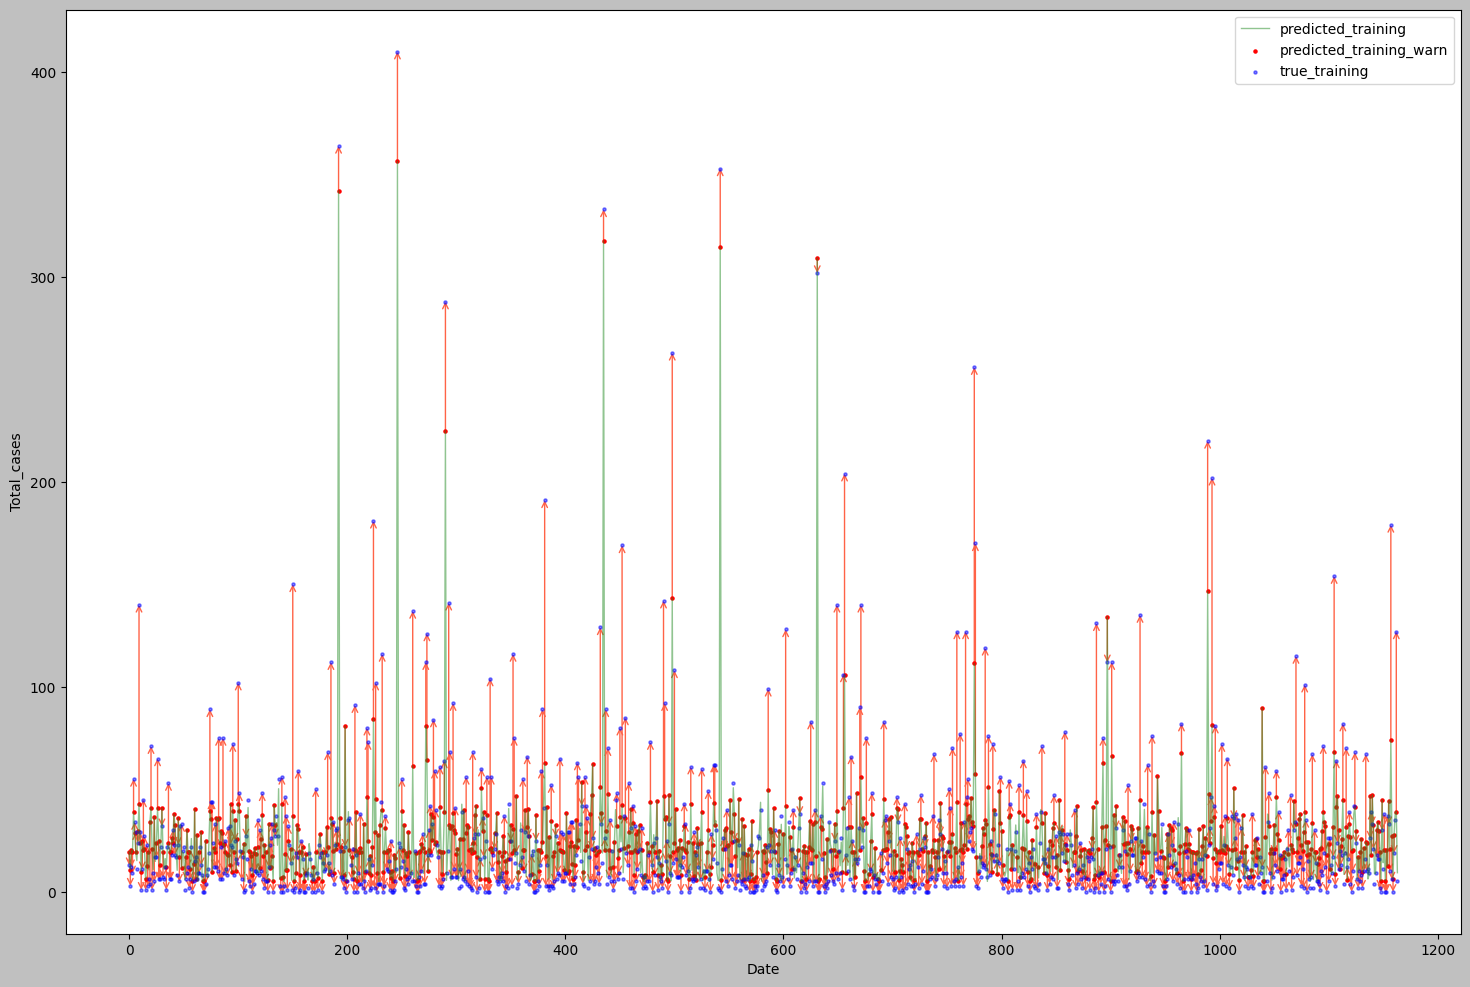

In [60]:
fig1, _, _= plot_predictions_line(model_forest, 
                                  X_train, 
                                  y_train, 
                                  threshold=5, 
                                  linewidth=1, 
                                  legend_label_sufix='training', 
                                  on_connections=True, 
                                  figsize=(18, 12))

MAE metric: 16.348049990132576



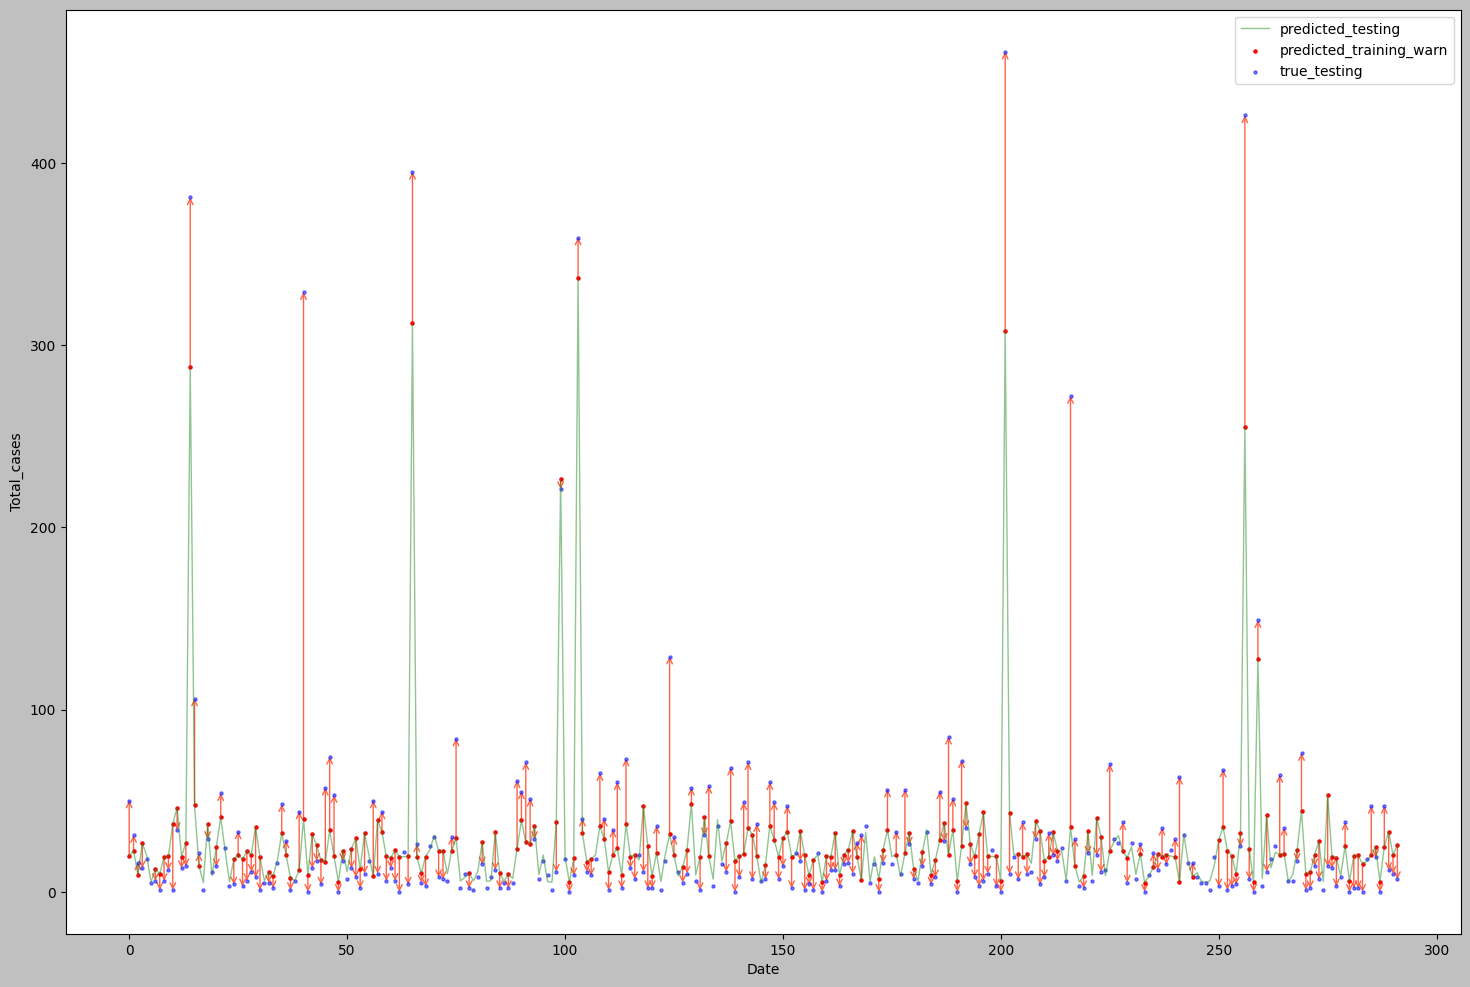

In [62]:
fig2, _, _= plot_predictions_line(model_forest, X_test, y_test, threshold=5, linewidth=1, legend_label_sufix='testing', on_connections=True, figsize=(18, 12))

Dummy regressor: classification is done through mean of target.

In [63]:
dummy_regressor_mean = y_train.mean()
dummy_regressor_mean

23.54553264604811

In [64]:
mean_absolute_error(np.ones_like(y_train) * dummy_regressor_mean, y_train)

21.574150340690355

In [65]:
mean_absolute_error(np.ones_like(y_test) * dummy_regressor_mean, y_test)

26.348720755072257

In [66]:
models_to_scores['base_dummy_mean'] = (mean_absolute_error(np.ones_like(y_train) * dummy_regressor_mean, y_train),
                                       mean_absolute_error(np.ones_like(y_test) * dummy_regressor_mean, y_test)
                                       )

Feature importance from base model

In [114]:
def importances_from_trees(model, columns, on_acum=False):
  s_importances = 100 * pd.Series(dict(zip(final_columns, model.feature_importances_)))
  s_importances.sort_values(inplace=True, ascending=False)

  fig, axes = plt.subplots(1, 1, figsize=(10, 6))
  axes.bar(x=s_importances.index.tolist(), height=s_importances.cumsum().values)
  for item in axes.get_xticklabels():
      item.set_rotation(45)
  plt.tight_layout()

  return s_importances, axes

Random forest

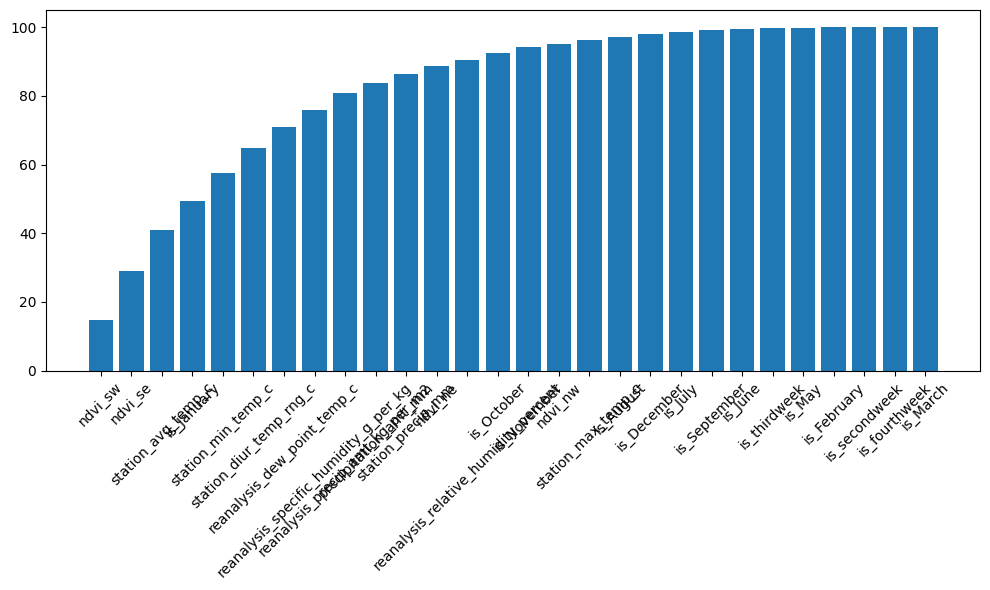

In [115]:
_ = importances_from_trees(model_forest, final_columns)

Gradient boosting

(ndvi_se                                  21.290850
 is_January                               15.745996
 station_avg_temp_c                       13.979954
 station_min_temp_c                        9.323148
 ndvi_sw                                   6.020658
 reanalysis_specific_humidity_g_per_kg     5.742163
 station_diur_temp_rng_c                   5.464313
 reanalysis_dew_point_temp_c               3.290764
 reanalysis_precip_amt_kg_per_m2           3.003119
 ndvi_ne                                   3.002504
 ndvi_nw                                   1.920534
 station_max_temp_c                        1.857944
 is_June                                   1.518569
 is_November                               1.294324
 is_May                                    1.208258
 reanalysis_relative_humidity_percent      1.207734
 precipitation_amt_mm                      1.190331
 is_October                                1.081231
 is_December                               0.544317
 station_pre

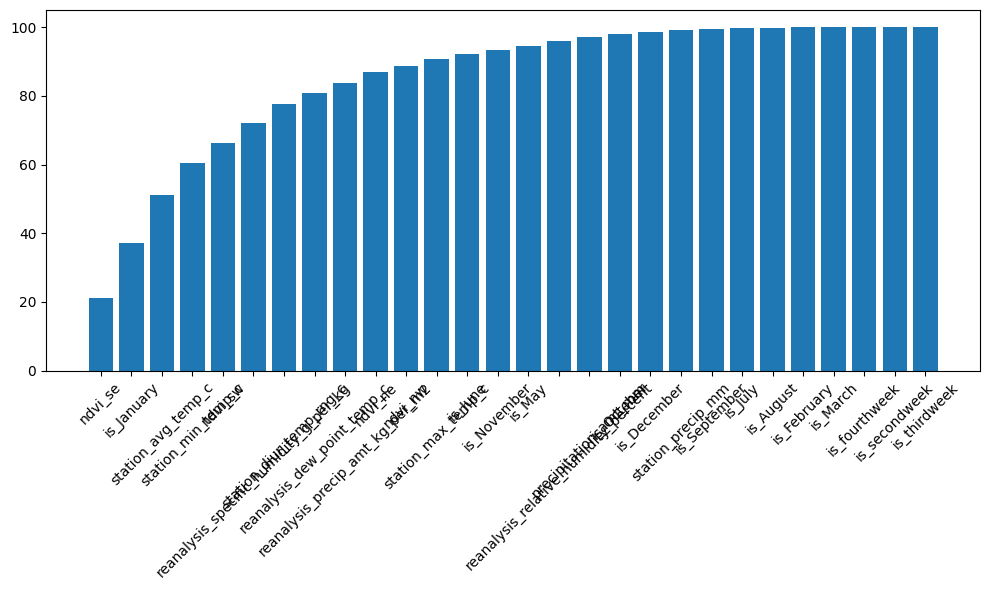

In [116]:
importances_from_trees(model_gradient_boosting, final_columns, on_acum=True)

### Feature selection through base model (random Forest)

In [159]:
def features_from_model(model, X, y, threshold=0.03, test_size=0.15, prefit=True):
  selector = SelectFromModel(model_forest, threshold=threshold, prefit=prefit)
  X_feature_selection = selector.transform(X)

  return split_scale(X_feature_selection, y, test_size=test_size)

Split again and evaluate a new model

In [118]:
X_train_fs, X_test_fs, y_train, y_test = features_from_model(model_forest, X, y, test_size=0.15)

In [119]:
X_train_fs.shape

(1237, 9)

### Grid search method for tuning

In [120]:
#SCORERS

In [214]:
params_forest = {'n_estimators': [100, 150, 200, 250], 
                 'max_depth': [2, 3, 5, 7, 8, 10],
                 "max_features": [1.0, "log2", "sqrt"]
                 }

params_tree = {
               'max_depth': [2, 3, 5],
               'min_samples_split': [2, 5],
               }

params_sgd = {
    'alpha': np.linspace(0.0001, 0.1, 5),
    }

params_gb = {'n_estimators': [100, 150, 200, 250],
             'max_depth': [2, 3, 5, 7],
             'subsample': [0.6, 0.8, 1.0],
             "max_features": [1.0, "log2", "sqrt"]
             }

params_lasso = {'alpha': [0.1, 1, 5]
                }

params_ridge = {'alpha': [0.1, 1, 5]
                }

params_svr_rbf = {'gamma': ['scale', 'auto'],
                  'C': [10, 1.0, 0.1],
                  'coef0': [0.0, 0.5, 1.0],
                  'epsilon': [0.05, 0.1, 0.5]
                  }

params_svr_poly = {'degree': [2, 3],
                   'C': [10, 1.0, 0.1],
                   'coef0': [0.0, 0.5, 1.0],
                   'epsilon': [0.05, 0.1, 0.5]
                   }

params_svr_linear = {'C': [10, 1.0, 0.1],
                     'coef0': [0.0, 0.5, 1.0],
                     'epsilon': [0.05, 0.1, 0.5]
                     }

#params_gds = [params_sgd, params_tree, params_forest, params_lasso, params_ridge, params_svr_rbf, params_svr_poly, params_svr_linear]
params_gds = [params_forest, params_gb]

In [211]:
refit_score = 'neg_mean_absolute_error'
scorings = ['neg_mean_absolute_error', 'neg_mean_squared_error']

# Individual models
model_forest = RandomForestRegressor(random_state=RANDOM_STATE, 
                                     criterion="squared_error", #poisson
                                     max_features="sqrt",
                                     n_jobs=-1
                                     )
model_gradient_boosting = GradientBoostingRegressor(random_state=RANDOM_STATE, 
                                                    criterion="squared_error", #friedman_mse
                                                    max_features="sqrt",
                                                    loss="squared_error"
                                                    )
model_tree = DecisionTreeRegressor(random_state=RANDOM_STATE)
model_lasso = Lasso(max_iter=2000, random_state=RANDOM_STATE)
model_ridge = Ridge(random_state=RANDOM_STATE)
model_svr_rbf = SVR(kernel='rbf')
model_svr_poly = SVR(kernel='poly')
model_svr_linear = SVR(kernel='linear')

# Models with grid search method
model_gds_SGDReg = GridSearchCV(model_SGDReg, param_grid=params_sgd, cv=5, refit=refit_score, scoring=scorings, n_jobs=5)
model_gds_forest = GridSearchCV(model_forest, param_grid=params_forest, cv=5, refit=refit_score, scoring=scorings, n_jobs=5)
model_gds_gradient_boosting = GridSearchCV(model_gradient_boosting, param_grid=params_gb, cv=5, refit=refit_score, scoring=scorings, n_jobs=5)
model_gds_tree = GridSearchCV(model_tree, param_grid=params_tree, cv=5, refit=refit_score, scoring=scorings, n_jobs=5)
model_gds_lasso = GridSearchCV(model_lasso, param_grid=params_lasso, cv=5, refit=refit_score, scoring=scorings, n_jobs=5)
model_gds_ridge = GridSearchCV(model_ridge, param_grid=params_ridge, cv=5, refit=refit_score, scoring=scorings, n_jobs=5)
model_gds_svr_rbf = GridSearchCV(model_svr_rbf, param_grid=params_svr_rbf, cv=5, refit=refit_score, scoring=scorings, n_jobs=5)
model_gds_svr_poly = GridSearchCV(model_svr_poly, param_grid=params_svr_poly, cv=5, refit=refit_score, scoring=scorings, n_jobs=5)
model_gds_svr_linear = GridSearchCV(model_svr_linear, param_grid=params_svr_linear, cv=5, refit=refit_score, scoring=scorings, n_jobs=5)

#models_gds = [model_gds_SGDReg, model_gds_forest, model_gds_tree, model_gds_lasso, model_gds_ridge, model_gds_svr_rbf, model_gds_svr_poly, model_gds_svr_linear]
models_gds = [model_gds_forest, model_gds_gradient_boosting]

In [215]:
models_gds

[GridSearchCV(cv=5,
              estimator=RandomForestRegressor(max_features='sqrt', n_jobs=-1,
                                              random_state=117),
              n_jobs=5,
              param_grid={'max_depth': [2, 3, 5, 7, 8, 10],
                          'max_features': ['auto', 'log2', 'sqrt'],
                          'n_estimators': [100, 150, 200, 250]},
              refit='neg_mean_absolute_error',
              scoring=['neg_mean_absolute_error', 'neg_mean_squared_error']),
 GridSearchCV(cv=5,
              estimator=GradientBoostingRegressor(criterion='squared_error',
                                                  max_features='sqrt',
                                                  random_state=117),
              n_jobs=5,
              param_grid={'max_depth': [2, 3, 5, 7],
                          'max_features': ['auto', 'log2', 'sqrt'],
                          'n_estimators': [100, 150, 200, 250],
                          'subsample': [0.6, 0.8,

In [212]:
X_train.shape, y_train.shape

((1164, 28), (1164,))

In [213]:
is_trained = False

if not is_trained:
  for model in models_gds:
    # when using metric 'neg_mean_poisson_deviance', this error occurs: Mean Tweedie deviance error with power=1 can only be used on non-negative y_true and strictly positive y_pred.
    model.fit(X_train, y_train)
    # Best parameters
    print(str(model.estimator).split('(')[0])
    print(model.best_params_)
    print("Best score:", -model.best_score_)
    print("Best mae:", mean_absolute_error(y_test, model.predict(X_test)), sep="\n")
    print("Best sme:", mean_squared_error(y_test, model.predict(X_test)), sep="\n")
  is_trained = True
else:
  print('already trained')

C:\Users\marsu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


RandomForestRegressor
{'max_depth': 10, 'max_features': 'auto', 'n_estimators': 200}
Best score: 17.004374122607956
Best mae:
16.154392655797245
Best sme:
1040.1134782981276
GradientBoostingRegressor
{'max_depth': 3, 'max_features': 'log2', 'n_estimators': 100, 'subsample': 1.0}
Best score: 16.869974141803834
Best mae:
16.392357494249012
Best sme:
1271.8922088599686


In [218]:
models_to_scores['RF_gds_1'] = (mean_absolute_error(y_train, models_gds[0].predict(X_train)),
                                mean_absolute_error(y_test, models_gds[0].predict(X_test))
                                )

### Model and error evaluation 

MAE metric: 9.689085503950533



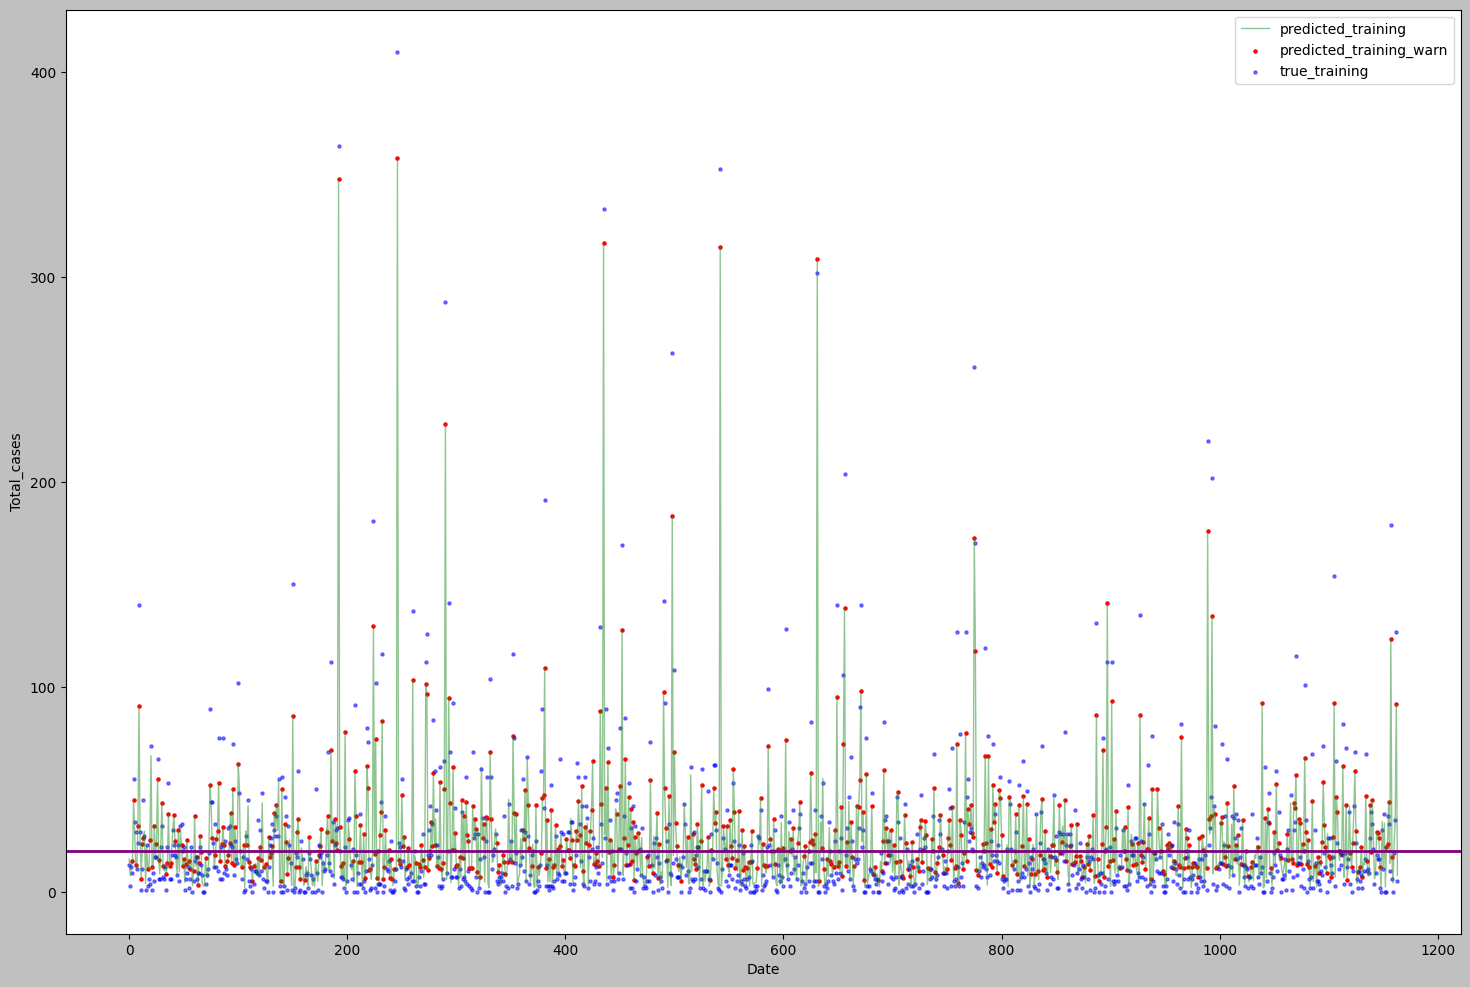

In [216]:
fig3, _, _= plot_predictions_line(models_gds[0], X_train, y_train, threshold=5, linewidth=1, legend_label_sufix='training', on_connections=False, figsize=(18, 12))
plt.axhline(20, -5, 1200, color='purple', linewidth=2)

MAE metric: 20.402340425531914



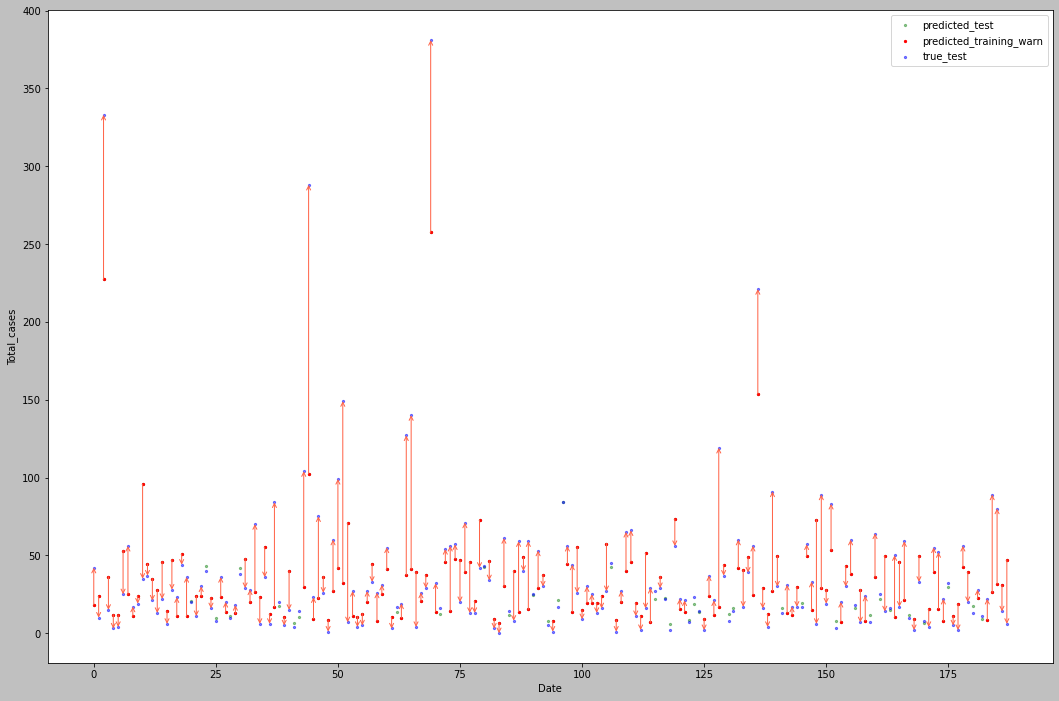

In [ ]:
fig4, _, _ = plot_predictions_line(models_gds[0], X_test, y_test, threshold=5, linewidth=1, legend_label_sufix='test', on_connections=True, figsize=(18, 12))

Weight high values

In [219]:
lower_bound_weighting = 5
base_total_cases = pd.Series(y_train)#features_for_model.total_cases

which_cases_to_weight = base_total_cases.gt(lower_bound_weighting).astype(int)
main_weighting = base_total_cases.div(base_total_cases.max())

# If we built a vector of weights normalized to unit, the model will perform worse
#total_cases_weights = base_total_cases.div(base_total_cases.max())

total_cases_weights = 1 + which_cases_to_weight * main_weighting
total_cases_weights.sort_values(ascending=False).head(10), total_cases_weights.shape

(246    2.000000
 192    1.887805
 542    1.860976
 435    1.812195
 631    1.736585
 290    1.702439
 498    1.641463
 775    1.624390
 989    1.536585
 656    1.497561
 dtype: float64,
 (1164,))

Weight values inside distribution

In [220]:
base_total_cases = pd.Series(y_train)

median = base_total_cases.median()
IQR = base_total_cases.quantile(0.75) - base_total_cases.quantile(0.25)

which_cases_to_weight = ~base_total_cases.between(median - IQR, median + IQR)
main_weighting = base_total_cases.div(base_total_cases.max())**2

# If we built a vector of weights normalized to unit, the model will perform worse
#total_cases_weights = base_total_cases.div(base_total_cases.max())

total_cases_weights = 1 - which_cases_to_weight * main_weighting
total_cases_weights.sort_values(ascending=False).head(20), total_cases_weights.shape

(0      1.0
 744    1.0
 727    1.0
 728    1.0
 729    1.0
 730    1.0
 731    1.0
 732    1.0
 733    1.0
 734    1.0
 735    1.0
 736    1.0
 739    1.0
 740    1.0
 741    1.0
 742    1.0
 745    1.0
 528    1.0
 746    1.0
 747    1.0
 dtype: float64,
 (1164,))

Evaluate all models with weighted on examples

In [1]:
refit_score='neg_mean_absolute_error'
scorings = ['neg_mean_absolute_error', 'neg_mean_squared_error']

params_forest = {'n_estimators': [100, 150, 200, 250], 
                 'max_depth': [2, 3, 5, 7, 8, 10],
                 "max_features": [1.0, "log2", "sqrt"]
                 }

params_gb = {'n_estimators': [100, 150, 200, 250],
             'max_depth': [2, 3, 5, 7],
             'subsample': [0.6, 0.8, 1.0],
             "max_features": [1.0, "log2", "sqrt"]
             }

#params_gds = [params_sgd, params_tree, params_forest, params_lasso, params_ridge, params_svr_rbf, params_svr_poly, params_svr_linear]
params_gds = [params_forest, params_gb]

refit_score = 'neg_mean_absolute_error'
scorings = ['neg_mean_absolute_error', 'neg_mean_squared_error']

# Individual models
model_forest_weights = RandomForestRegressor(random_state=RANDOM_STATE, 
                                     criterion="squared_error", #poisson
                                     max_features="sqrt",
                                     n_jobs=-1
                                     )
model_gradient_boosting_weights = GradientBoostingRegressor(random_state=RANDOM_STATE, 
                                                    criterion="squared_error", #friedman_mse
                                                    max_features="sqrt",
                                                    loss="squared_error"
                                                    )

model_gds_gradient_boosting_weights = GridSearchCV(model_forest_weights, 
                                                   param_grid=params_forest, 
                                                   cv=5, 
                                                   refit=refit_score, 
                                                   scoring=scorings, 
                                                   n_jobs=5)

model_gds_forest_weights = GridSearchCV(model_gradient_boosting_weights, 
                                        param_grid=params_gb, 
                                        cv=5, 
                                        refit=refit_score, 
                                        scoring=scorings, 
                                        n_jobs=5)

models_weights = [model_gds_gradient_boosting_weights, 
                  model_gds_forest_weights]

NameError: name 'RandomForestRegressor' is not defined

In [222]:
is_trained = False

if not is_trained:
  for model in models_weights:
    # when using metric 'neg_mean_poisson_deviance', this error occurs: Mean Tweedie deviance error with power=1 can only be used on non-negative y_true and strictly positive y_pred.
    model.fit(X_train, y_train, sample_weight=total_cases_weights)

    # Best parameters
    print(str(model.estimator).split('(')[0])
    print(model.best_params_)
    print(-model.best_score_, '\n--------------------------------------------------')
    print(mean_absolute_error(y_test, model.predict(X_test)))

  is_trained = True
else:
  print('already trained')

: 

MAE metric: 15.356991978609626



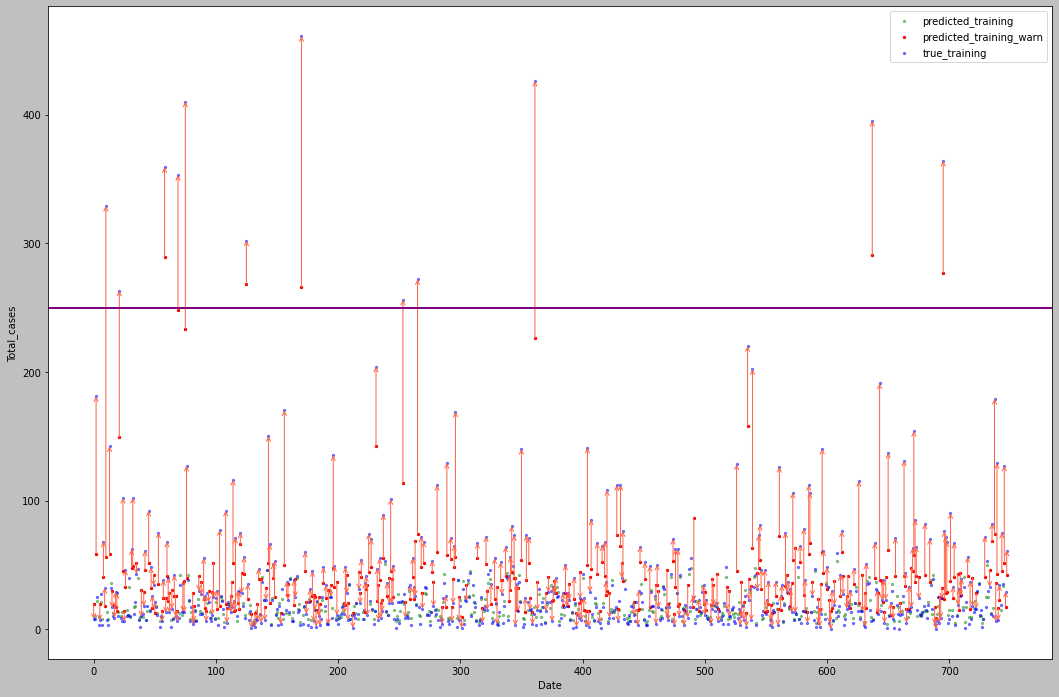

In [ ]:
fig5, _, _= plot_predictions_line(model_gds_forest_weights, X_train, y_train, threshold=8, linewidth=1, legend_label_sufix='training', on_connections=True, figsize=(18, 12))
plt.axhline(250, -5, 1200, color='purple', linewidth=2)

MAE metric: 19.29278368794326



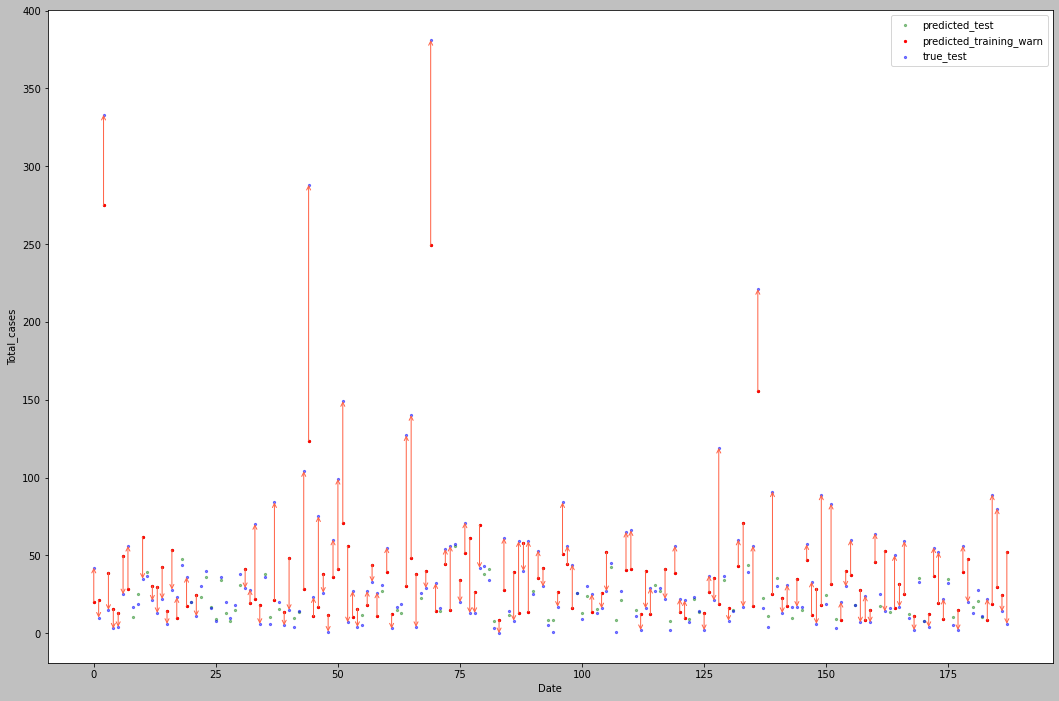

In [ ]:
fig6, _, _ = plot_predictions_line(model_gds_forest_weights, X_test, y_test, threshold=8, linewidth=1, legend_label_sufix='test', on_connections=True, figsize=(18, 12))

In [ ]:
models_to_scores['RF_gds_weights'] = (mean_absolute_error(y_train, model_gds_forest_weights.predict(X_train)),
                                      mean_absolute_error(y_test, model_gds_forest_weights.predict(X_test))
                                      )

From both plots we can conclude the model is limited to predictions approximately over 250 total_cases, as we can see on both training and test plots. This might happened due to improper value imputation on outliers. We could reimpute outliers with higher limit values (like 2.5 IQR) or keep original outlier values.

Classical time series models

In [ ]:
from statsmodels.tsa.arima_model import ARIMA, ARMA
from statsmodels.tsa.holtwinters import Holt
from statsmodels.tsa.ar_model import AR
from statsmodels.api.tsa.statespace.SARIMAX import SARIMAX
from statsmodels.tsa.seasonal import s
from statsmodels.tsa._exponential_smoothers import

### Boosting, voting and stacking

#### Boosting with grid-search

In [ ]:
model_ada_treeStump = AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=1))
model_ada_svr_rbf = AdaBoostRegressor(base_estimator=SVC(kernel='rbf'), )

NameError: ignored

In [ ]:
refit_score='neg_mean_absolute_error'
scorings = ['neg_mean_absolute_error', 'neg_mean_squared_error']

params_ada_tree = {'n_estimators': [100, 150, 200],
                   'learning_rate': [0.01, 0.1],
                   'loss': ['linear', 'square', 'exponential'],
                    'base_estimator__criterion': ['mse', 'mae'],
                    'base_estimator__max_depth': [3, 5, 7, 10],
                    'base_estimator__min_samples_split': [2, 5, 10],
                    'base_estimator__min_samples_leaf': [2, 5],
                    'base_estimator__max_features': ['auto', 'sqrt']
                   }

params_svr_rbf = {'gamma': ['scale', 'auto'],
                  'C': [10, 1.0, 0.5],
                  }

model_ada_tree = AdaBoostRegressor(base_estimator=DecisionTreeRegressor(random_state=RANDOM_STATE), random_state=RANDOM_STATE)
model_ada_svr_rbf = AdaBoostRegressor(base_estimator=SVR(kernel='rbf'), random_state=RANDOM_STATE)

model_gds_ada_tree = GridSearchCV(model_ada_tree, param_grid=params_ada_tree, cv=5, refit=refit_score, scoring=scorings, n_jobs=-1)
model_gds_svr_rbf = GridSearchCV(model_ada_svr_rbf, param_grid=params_svr_rbf, cv=5, refit=refit_score, scoring=scorings, n_jobs=-1)

In [ ]:
for model_gds_ada in [model_gds_ada_tree, model_gds_svr_rbf]:
  model_gds_ada.fit(X_train, y_train)
  # Best parameters
  print(str(model_gds_ada.estimator).split('(')[0])
  print(model_gds_ada.best_params_)
  print(-model_gds_ada.best_score_, '\n--------------------------------------------------')

KeyboardInterrupt: ignored

Voting

In [ ]:
model_vote_rfr = RandomForestRegressor(n_estimators=150, max_depth=7, min_samples_leaf=3, criterion='absolute_error', random_state=RANDOM_STATE)
model_vote_gbr = GradientBoostingRegressor(n_estimators=100, max_depth=7, min_samples_leaf=3, criterion='absolute_error', random_state=RANDOM_STATE)

model_voting_soft = VotingRegressor(estimators=[('gbr', model_vote_rfr), ('rfr', model_vote_gbr)])

In [ ]:
model_voting_soft.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1855: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


VotingRegressor(estimators=[('gbr',
                             RandomForestRegressor(criterion='absolute_error',
                                                   max_depth=7,
                                                   min_samples_leaf=3,
                                                   n_estimators=150,
                                                   random_state=117)),
                            ('rfr',
                             GradientBoostingRegressor(criterion='absolute_error',
                                                       max_depth=7,
                                                       min_samples_leaf=3,
                                                       random_state=117))])

MAE metric: 16.78647597309445



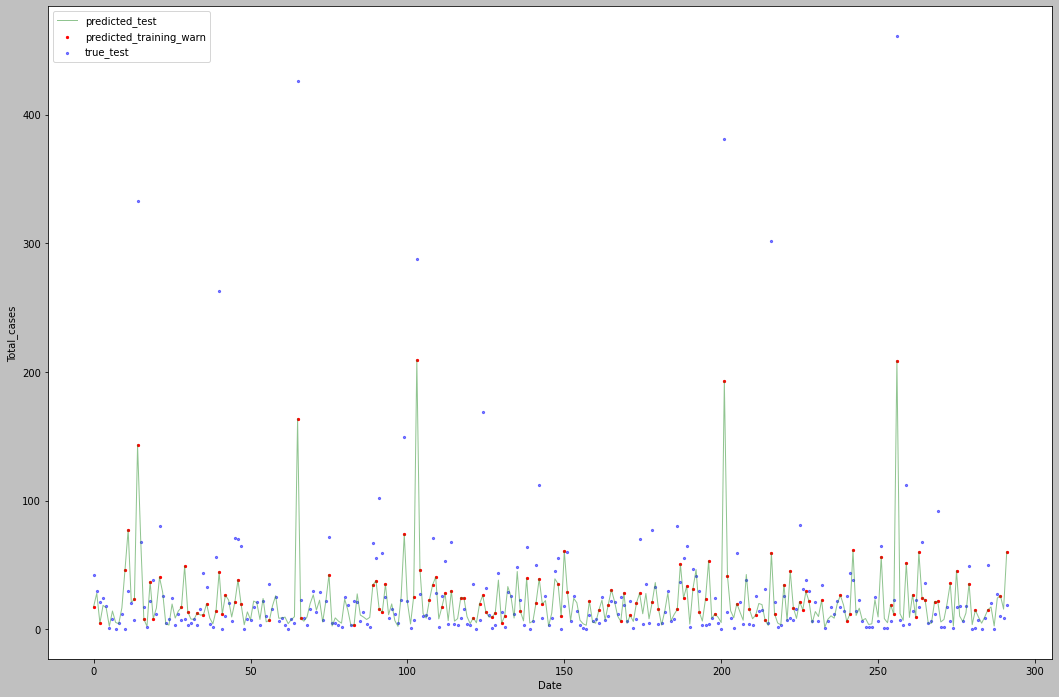

In [ ]:
fig13, _, _ = plot_predictions_line(model_voting_soft, X_test, y_test, threshold=8, linewidth=1, legend_label_sufix='test', on_connections=False, figsize=(18, 12))

Stacking with grid-search

In [ ]:
final_layer_rfr = RandomForestRegressor(n_estimators=150, min_samples_leaf=3, criterion='absolute_error', max_depth=7,random_state=RANDOM_STATE)
final_layer_gbr = GradientBoostingRegressor(n_estimators=100, min_samples_leaf=3, criterion='absolute_error', random_state=RANDOM_STATE)

final_layer = StackingRegressor(estimators=[('rf', final_layer_rfr), 
                                            ('gbrt', final_layer_gbr)],
                                final_estimator=RidgeCV()
                                )

multi_layer_regressor = StackingRegressor(estimators=[('ridge', RidgeCV()),
                                                      ('lasso', LassoCV(random_state=42)),
                                                      ('knr', KNeighborsRegressor(n_neighbors=20,
                                                                                  metric='euclidean'))],
                                          final_estimator=final_layer)
multi_layer_regressor.fit(X_train, y_train)

print('R2 score: {:.2f}'
      .format(multi_layer_regressor.score(X_test, y_test)))

In [ ]:
model_stack_tree = StackingRegressor()

### TensorFlow

In [ ]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])
  
  def split_window(self, features):
    inputs = features[:, self.input_slice, :]
    labels = features[:, self.labels_slice, :]
    if self.label_columns is not None:
      labels = tf.stack(
          [labels[:, :, self.column_indices[name]] for name in self.label_columns],
          axis=-1)

    # Slicing doesn't preserve static shape information, so set the shapes
    # manually. This way the `tf.data.Datasets` are easier to inspect.
    inputs.set_shape([None, self.input_width, None])
    labels.set_shape([None, self.label_width, None])

    return inputs, labels

  WindowGenerator.split_window = split_window

  def make_dataset(self, data):
    data = np.array(data, dtype=np.float32)
    ds = tf.keras.preprocessing.timeseries_dataset_from_array(
        data=data,
        targets=None,
        sequence_length=self.total_window_size,
        sequence_stride=1,
        shuffle=True,
        batch_size=32,)

    ds = ds.map(self.split_window)

    return ds

  WindowGenerator.make_dataset = make_dataset
  
  @property
  def train(self):
    return self.make_dataset(self.train_df)

  @property
  def val(self):
    return self.make_dataset(self.val_df)

  @property
  def test(self):
    return self.make_dataset(self.test_df)

  @property
  def example(self):
    """Get and cache an example batch of `inputs, labels` for plotting."""
    result = getattr(self, '_example', None)
    if result is None:
      # No example batch was found, so get one from the `.train` dataset
      result = next(iter(self.train))
      # And cache it for next time
      self._example = result
    return result

  WindowGenerator.train = train
  WindowGenerator.val = val
  WindowGenerator.test = test
  WindowGenerator.example = example





In [ ]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
  early_stopping = callbacks.EarlyStopping(monitor='val_loss',
                                           patience=patience,
                                           mode='min')

  model.compile(loss=losses.MeanSquaredError(),
                optimizer=optimizers.Adam(),
                metrics=[metrics.MeanAbsoluteError()])
  
  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

In [ ]:
window = WindowGenerator(
    input_width=4, label_width=1, shift=1,
    label_columns=['total_cases'])

window

In [ ]:
class LayerBooster(layers.Layer):
  def __init__(self, units=32, activation='relu'):
    super(LayerBooster, self).__init__()
    self.units = units
    self.activation = activation

  def build(self, input_shape):
      self.w = self.add_weight(shape=(input_shape[-1], self.units),
                               initializer='random_normal',
                               trainable=True)
      self.b = self.add_weight(shape=(self.units,),
                               initializer='random_normal',
                               trainable=True)
      self.boost = self.add_weight(shape=(self.units,),
                               initializer='random_normal',
                               trainable=True)

  def call(self, inputs):
      return self.boost * activations.relu(tf.matmul(inputs, self.w) + self.b)

In [ ]:
def model_lstm(X, activation='relu', dropout_freq=0.1, loss=losses.MeanAbsoluteError(), on_average_seq=True):
  input_shape = (X.shape[1], X.shape[2])
  model_seq = Sequential()

  # Input layer
  model_seq.add(layers.Input(shape=input_shape))
  # Long-Short Term Memory layer
  model_seq.add(layers.LSTM(64, return_sequences=on_average_seq))
  if on_average_seq:
    model_seq.add(layers.GlobalAveragePooling1D())
  # Dense layer
  model_seq.add(layers.Dense(128, activation='relu'))
  model_seq.add(layers.Dropout(dropout_freq))
  # Output layer
  model_seq.add(layers.Dense(1, activation='linear'))
  
  model_seq.compile(loss=loss,
                    optimizer='adam',
                    metrics=[metrics.MeanAbsoluteError()])
  
  return model_seq

def model_dense(X, activation='relu', dropout_freq=0.1, loss=losses.MeanAbsoluteError()):
  input_shape = (X.shape[1], )
  model_seq = Sequential()

  # Input layer
  model_seq.add(layers.Input(shape=input_shape))
  # Dense 1 layer
  model_seq.add(layers.Dense(64, activation=activation))
  model_seq.add(layers.Dropout(dropout_freq))
  # Dense 2 layer
  model_seq.add(layers.Dense(128, activation=activation))
  model_seq.add(layers.Dropout(dropout_freq))
  # Output layer
  model_seq.add(layers.Dense(1, activation='linear'))
  
  model_seq.compile(loss=loss,
                    optimizer='adam',
                    metrics=[metrics.MeanAbsoluteError()]) # metrics.MeanSquaredError()
  
  return model_seq

def model_dense_boost(X, activation='relu', dropout_freq=0.1, loss=losses.MeanAbsoluteError()):
  input_shape = (X.shape[1], )
  model_seq = Sequential()

  # Input layer
  model_seq.add(layers.Input(shape=input_shape))
  # Dense 1 layer
  model_seq.add(LayerBooster(64, activation=activation))
  #model_seq.add(layers.Dropout(dropout_freq))
  # Dense 2 layer
  model_seq.add(LayerBooster(128, activation=activation))
  #model_seq.add(layers.Dropout(dropout_freq))
  # Output layer
  model_seq.add(layers.Dense(1, activation='linear'))
  
  model_seq.compile(loss=loss,
                    optimizer='adam',
                    metrics=[metrics.MeanAbsoluteError()]) # metrics.MeanSquaredError()
  
  return model_seq

In [ ]:
def format_data_to_RNN(X, steps=50):
  if len(X.shape) == 1:
    X = X.reshape(-1, 1)
  n_examples, time_series = X.shape

  samples = []

  for i in range(0, n_examples, steps):
    sample = X[i:i + steps, :]
    temp_step = sample.shape[0]

    if temp_step < steps:
      sample = np.pad(sample, pad_width=[(0, steps - temp_step), (0, 0)], constant_values=0, mode='constant')
    #print(sample.shape)
    samples.append(sample)
  
  X_with_time = np.array(samples)

  return X_with_time

Model 1 (relu)

In [ ]:
tf.keras.backend.clear_session()

In [ ]:
epochs = 75
batch = 64
eval_split = 0.2
model_1 = model_dense(X_train, loss=losses.MeanAbsoluteError())

history1 = model_1.fit(X_train, y_train, batch_size=batch, epochs=epochs, validation_split=eval_split)

Epoch 1/75
15/15 [==============================] - 1s 15ms/step - loss: 23.4525 - mean_absolute_error: 23.4525 - val_loss: 21.0287 - val_mean_absolute_error: 21.0287
Epoch 2/75
15/15 [==============================] - 0s 5ms/step - loss: 22.2796 - mean_absolute_error: 22.2796 - val_loss: 19.6473 - val_mean_absolute_error: 19.6473
Epoch 3/75
15/15 [==============================] - 0s 5ms/step - loss: 21.0086 - mean_absolute_error: 21.0086 - val_loss: 18.1627 - val_mean_absolute_error: 18.1627
Epoch 4/75
15/15 [==============================] - 0s 5ms/step - loss: 20.1419 - mean_absolute_error: 20.1419 - val_loss: 17.2783 - val_mean_absolute_error: 17.2783
Epoch 5/75
15/15 [==============================] - 0s 5ms/step - loss: 19.6265 - mean_absolute_error: 19.6265 - val_loss: 16.6771 - val_mean_absolute_error: 16.6771
Epoch 6/75
15/15 [==============================] - 0s 4ms/step - loss: 19.1326 - mean_absolute_error: 19.1326 - val_loss: 16.2260 - val_mean_absolute_error: 16.2260
Epo

Evaluation on train and test sets

In [ ]:
model_1.evaluate(X_train, y_train), model_1.evaluate(X_test, y_test)

10/10 [==============================] - 0s 2ms/step - loss: 19.9039 - mean_absolute_error: 19.9039


([15.219242095947266, 15.219242095947266],
 [19.903911590576172, 19.903911590576172])

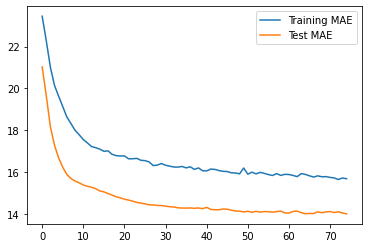

In [ ]:
train_mae1 = history1.history['mean_absolute_error']
eval_mae1 = history1.history['val_mean_absolute_error']
epochs_array = np.arange(0, epochs)

plt.plot(epochs_array, train_mae1, eval_mae1)
plt.legend(['Training MAE', 'Test MAE'])

Model 2 (Boost)

In [ ]:
tf.keras.backend.clear_session()

In [ ]:
epochs = 75
batch = 64
eval_split = 0.1
model_2 = model_dense_boost(X_train, loss=losses.MeanSquaredLogarithmicError())

history2 = model_2.fit(X_train, y_train, batch_size=batch, epochs=epochs, validation_split=eval_split, verbose=0)

In [ ]:
model_2.evaluate(X_train, y_train), model_2.evaluate(X_test, y_test)

10/10 [==============================] - 0s 2ms/step - loss: 1.0166 - mean_absolute_error: 20.7465


([0.9049526453018188, 15.963486671447754],
 [1.0165926218032837, 20.746536254882812])

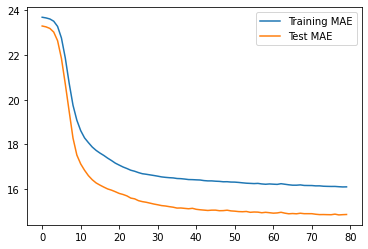

In [ ]:
train_mae2 = history2.history['mean_absolute_error']
eval_mae2 = history2.history['val_mean_absolute_error']
epochs_array = np.arange(0, epochs)

plt.plot(epochs_array, train_mae2, eval_mae2)
plt.legend(['Training MAE', 'Test MAE'])

Model 3 LSTM

In [ ]:
tf.keras.backend.clear_session()

In [ ]:
epochs = 100
batch = 64
eval_split = 0.2

X_train_times = format_data_to_RNN(X_train)
y_train_times = format_data_to_RNN(y_train)

model_3 = model_lstm(X_train_times, loss=losses.MeanAbsoluteError())
history3 = model_3.fit(X_train_times, y_train_times, batch_size=batch, epochs=epochs, validation_split=eval_split, verbose=0)

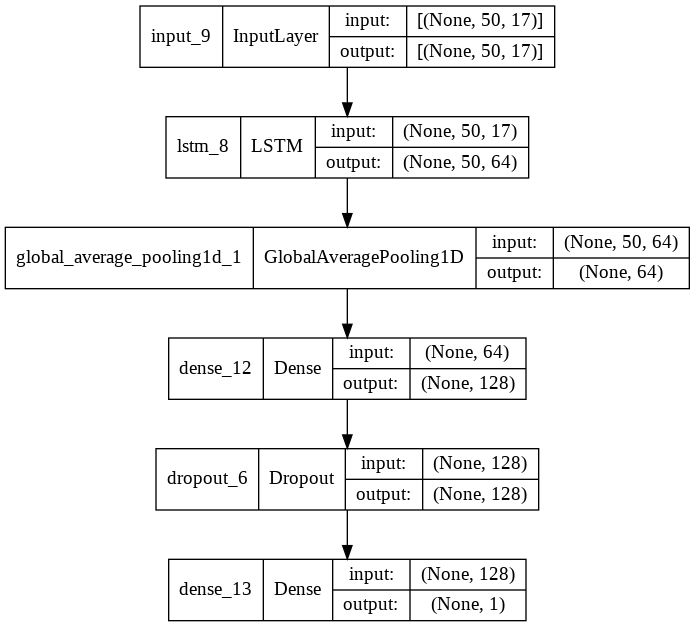

In [ ]:
tf.keras.utils.plot_model(model_3, show_shapes=True)

In [ ]:
X_test_times = format_data_to_RNN(X_test)
y_test_times = format_data_to_RNN(y_test)

model_3.evaluate(X_train_times, y_train_times), model_3.evaluate(X_test_times, y_test_times)

1/1 [==============================] - 0s 27ms/step - loss: 23.1704 - mean_absolute_error: 23.1704


([18.705041885375977, 18.705041885375977],
 [23.170425415039062, 23.170425415039062])

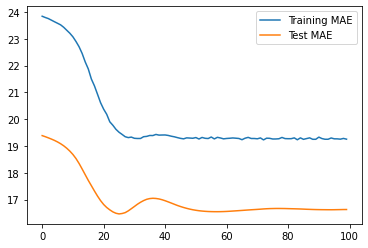

In [ ]:
train_mae3 = history3.history['mean_absolute_error']
eval_mae3 = history3.history['val_mean_absolute_error']
epochs_array = np.arange(0, epochs)

plt.plot(epochs_array, train_mae3, eval_mae3)
plt.legend(['Training MAE', 'Test MAE'])